# Analiza cen nieruchomości w Sacramento

In [1]:
# Importing the libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import missingno as msno
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib import colors

from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, KFold, cross_val_score

from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import plot_importance


# Import Neural Network libraries
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
# Opis zmiennych
d = {'Zmienna': ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude'],
     'Opis': ['Adres nieruchomości', 'Miasto', 'Kod pocztowy', 'Stan', 'Liczba pokoi', 'Liczba łazienek', 'Powierzchnia w stopach', 'Typ budynku- Rezydencja, Wielorodzinny, Condo', 'Data sprzedaży' , 'Cena', 'Szerekość geograficzna', 'Długość geograficzna']}
df = pd.DataFrame(data=d)
df

,Zmienna,Opis
0,street,Adres nieruchomości
1,city,Miasto
2,zip,Kod pocztowy
3,state,Stan
4,beds,Liczba pokoi
5,baths,Liczba łazienek
6,sq__ft,Powierzchnia w stopach
7,type,"Typ budynku- Rezydencja, Wielorodzinny, Condo"
8,sale_date,Data sprzedaży
9,price,Cena


## 1. Data exploration

In [3]:
# Wczytywanie danych 
df = pd.read_csv('Sacramento_real_estate_transactions.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sq__ft       985 non-null int64
type         985 non-null object
sale_date    985 non-null object
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.4+ KB


,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [4]:
#Opis zmiennej zależnej
df['price'].describe()

count       985.000000
mean     234144.263959
std      138365.839085
min        1551.000000
25%      145000.000000
50%      213750.000000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

In [5]:
print("Najbardziej skorelowane zmienne z ceną przed normalizacją i czyszczeniem danych")
corr = df.corr()
corr.sort_values(['price'], ascending=False, inplace=True)
corr.price

Najbardziej skorelowane zmienne z ceną przed normalizacją i czyszczeniem danych


price        1.000000
baths        0.416208
beds         0.342024
sq__ft       0.333897
longitude    0.284485
latitude    -0.039573
zip         -0.093353
Name: price, dtype: float64

In [6]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  7
Number of Categorical features:  5


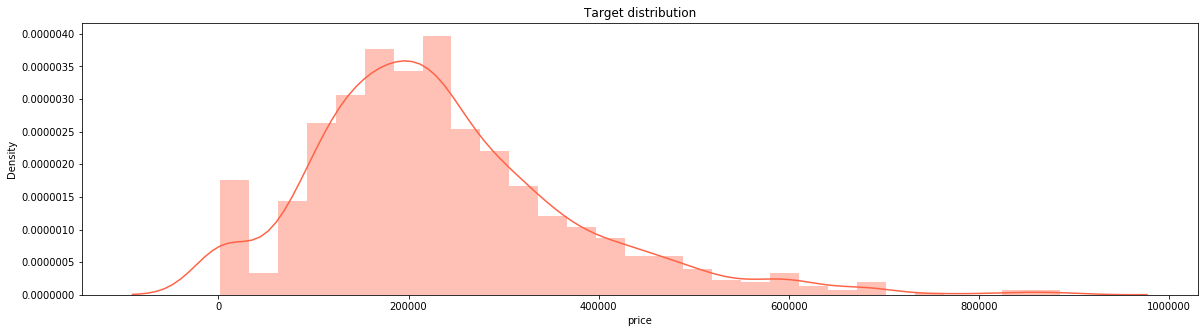

In [7]:
plt.figure(figsize=(20,5))
sns.distplot(df.price, color="tomato")
plt.title("Target distribution")
plt.ylabel("Density");

Rozkład zmiennej zależnej posiada asymetrie prawostronną

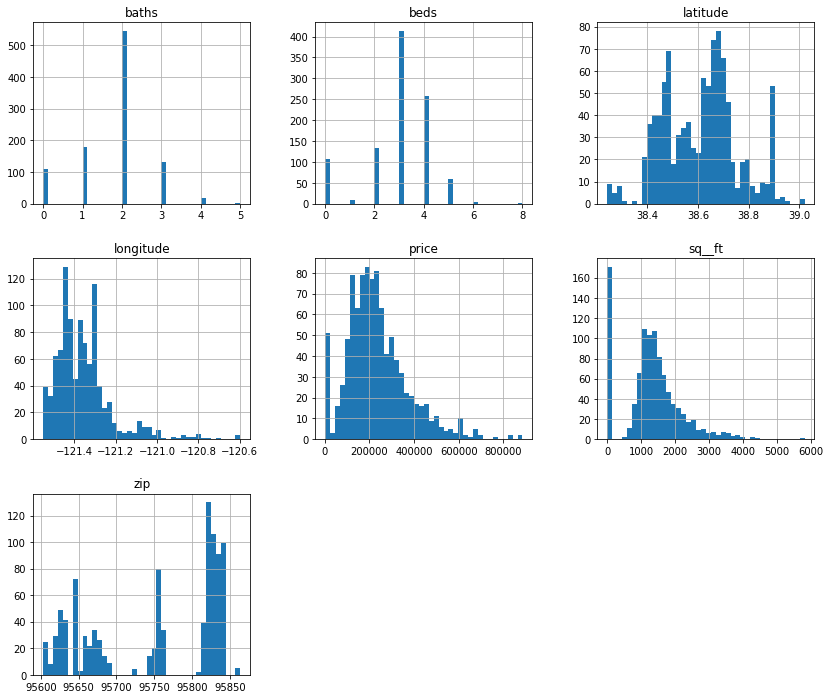

In [8]:
df.hist(bins=40, figsize=(14,12))
plt.show()

Obserwacje:

- zmienna 'sq__ft' posiada asymetrie prawostronną. W tym przypadku można zastąpić wszystkie zera medianą, jednak  większość z tych obserwacji ma także wartość 0 w innych kolumnach, zatem postanowiłem usunąć te wiersze.

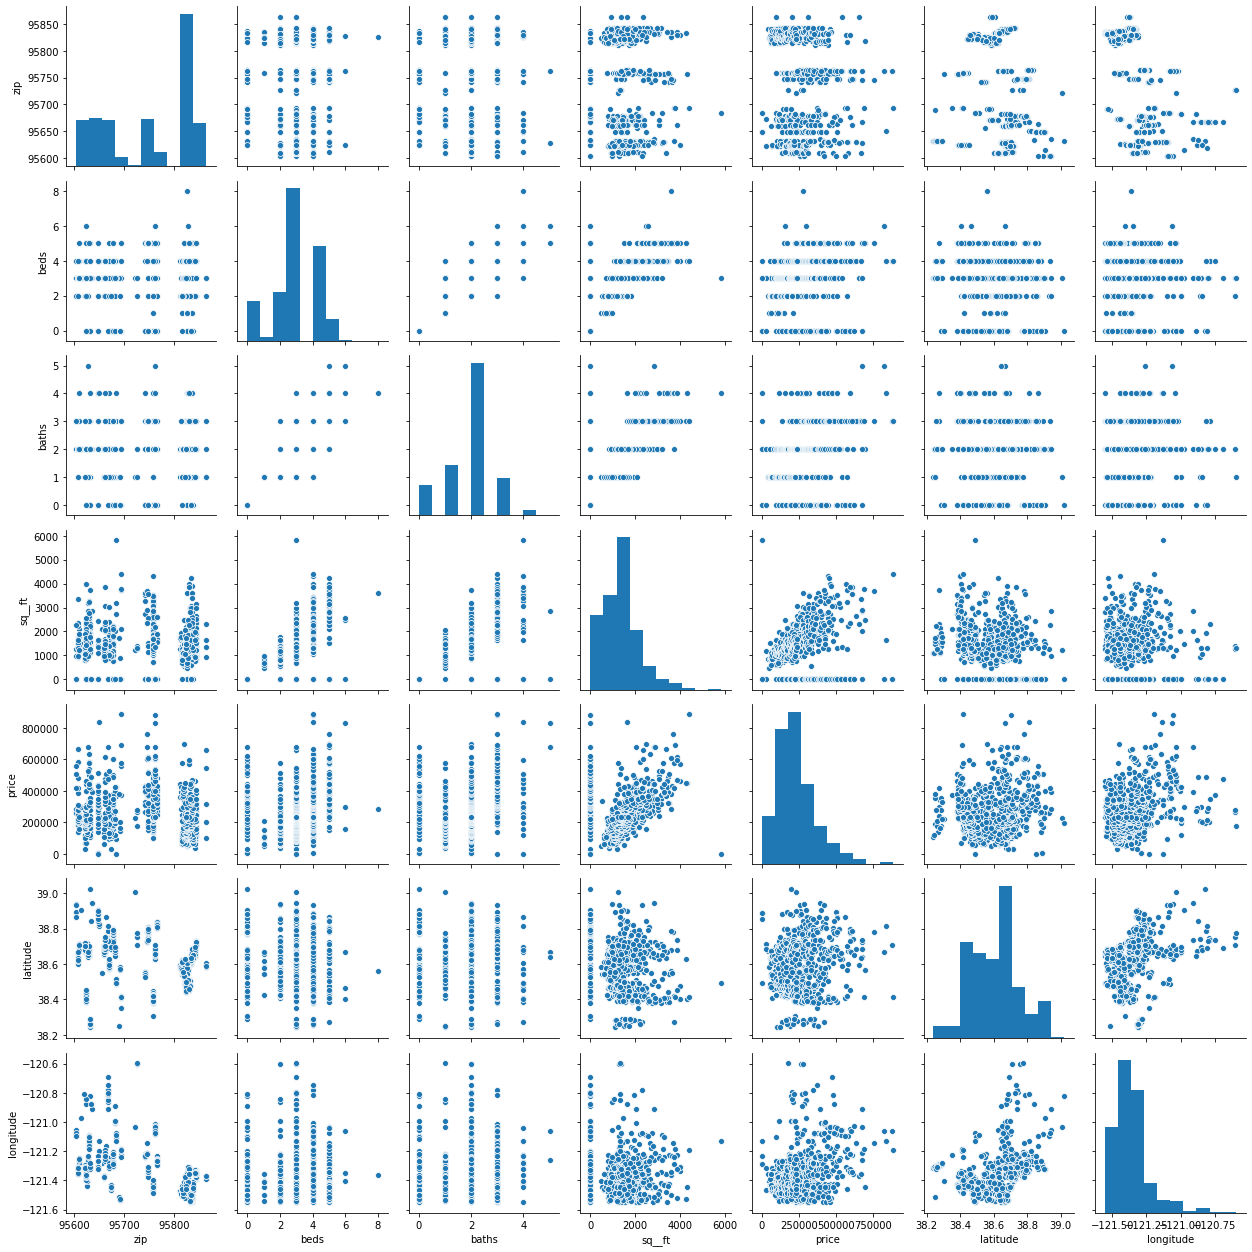

In [9]:
#Pairplots
%matplotlib inline
sns.pairplot(df, height=2.5)
plt.tight_layout()

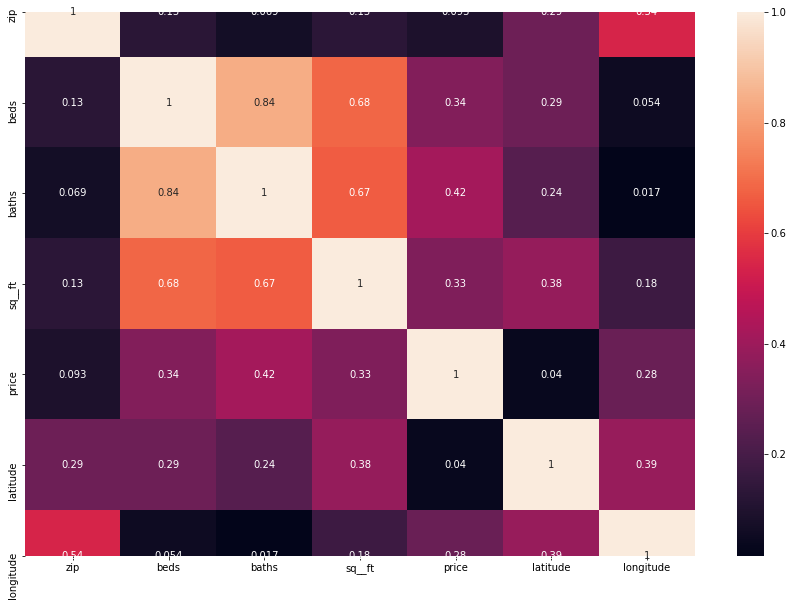

In [8]:
# Wykres korelacji Pearsona. 
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr().abs(),  annot=True)

Obserwacje:
- Jedyne zmienne, które są ze sobą silnie skorelowane to 'beds' oraz 'baths' jednak korelacja ta nie jest na tyle silna, aby odrzucać którąś z tych zmiennych. Później spróbuję stworzyć z tych dwóch zmiennych jedną zmienną - łączna liczba pomieszczeń. 



In [9]:
df.groupby('type').size()

type
Condo            54
Multi-Family     13
Residential     917
Unkown            1
dtype: int64

In [10]:
df['sale_date'].min()

'Fri May 16 00:00:00 EDT 2008'

In [11]:
df['sale_date'].max()

'Wed May 21 00:00:00 EDT 2008'

In [12]:
df[df['type'] == 'Condo'].mean()
# Dodać wykresy ze średnia ceną na metr na mieszkanie. Srednia pokoi, lazienek itp.

zip           95756.648148
beds              1.666667
baths             1.240741
sq__ft          760.425926
price        150082.185185
latitude         38.638827
longitude      -121.365441
dtype: float64

In [13]:
df[df['type'] == 'Multi-Family'].mean()

zip           95780.384615
beds              4.461538
baths             3.076923
sq__ft         2046.923077
price        224534.692308
latitude         38.597955
longitude      -121.352973
dtype: float64

In [14]:
df[df['type'] == 'Residential'].mean()

zip           95750.001091
beds              2.966194
baths             1.791712
sq__ft         1338.625954
price        239186.162486
latitude         38.606001
longitude      -121.355978
dtype: float64

Text(0.5, 1.0, 'price')

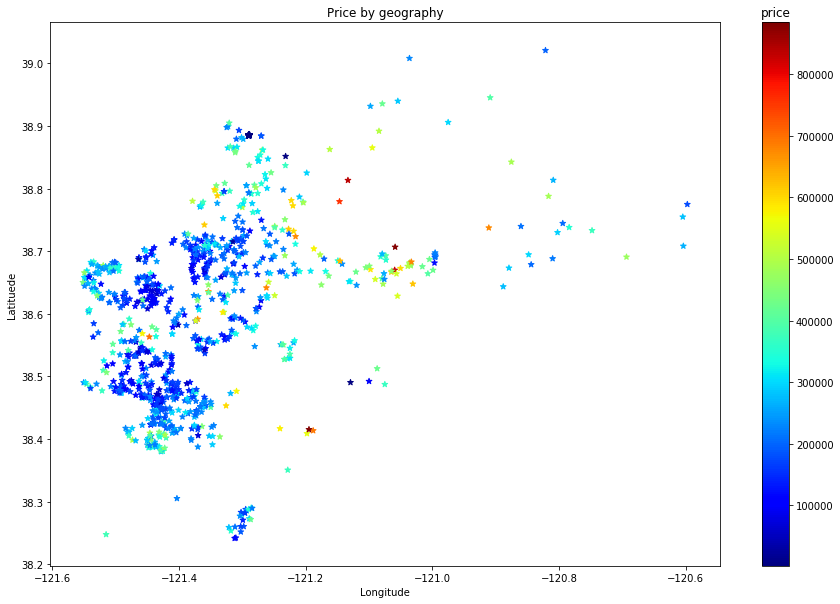

In [15]:
plt.figure(figsize=(15,10))
vmin = np.min(df.price)
vmax = np.max(df.price)
plt.scatter(df.longitude,df.latitude, marker='*',c=df.price,cmap='jet') 
plt.xlabel('Longitude')
plt.ylabel('Latituede')
plt.title('Price by geography')
clb = plt.colorbar() 
clb.ax.set_title('price')

## 2.Missing values and Data cleaning

In [16]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
longitude,0,0.0
latitude,0,0.0
price,0,0.0
sale_date,0,0.0
type,0,0.0


In [17]:
df['price'].describe()

count       985.000000
mean     234144.263959
std      138365.839085
min        1551.000000
25%      145000.000000
50%      213750.000000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

### 2.1 Outliers

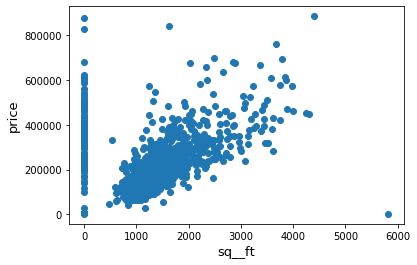

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = df['sq__ft'], y = df['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('sq__ft', fontsize=13)
plt.show()

In [18]:
# Pozbywamy się 
df['price'].loc[(df['price'] == 0)].count()

0

In [19]:
df['sq__ft'].loc[(df['sq__ft'] == 0)].count()

171

In [20]:
df['price'].loc[(df['price'] < 5000)].count()

51

In [19]:
# Usuwanie wszystkich wierszy w kolumnie 'price' w których wartość jest mniejsza niż 5000
df = df[df['price'] > 5000]

In [20]:
# Usuwanie wszystkich wierszy w kolumnie 'sq__ft' w których wartość wynosi 0
df = df[df['sq__ft'] != 0]

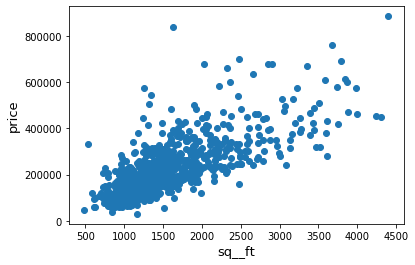

In [21]:
#Usuwanie obserwacji odstających - Ponowne sprawdzenie
fig, ax = plt.subplots()
ax.scatter(df['sq__ft'], df['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('sq__ft', fontsize=13)
plt.show()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813 entries, 0 to 984
Data columns (total 12 columns):
street       813 non-null object
city         813 non-null object
zip          813 non-null int64
state        813 non-null object
beds         813 non-null int64
baths        813 non-null int64
sq__ft       813 non-null int64
type         813 non-null object
sale_date    813 non-null object
price        813 non-null int64
latitude     813 non-null float64
longitude    813 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 82.6+ KB


### 2.3 target normalization


 mu = 229728.13 and sigma = 119559.43



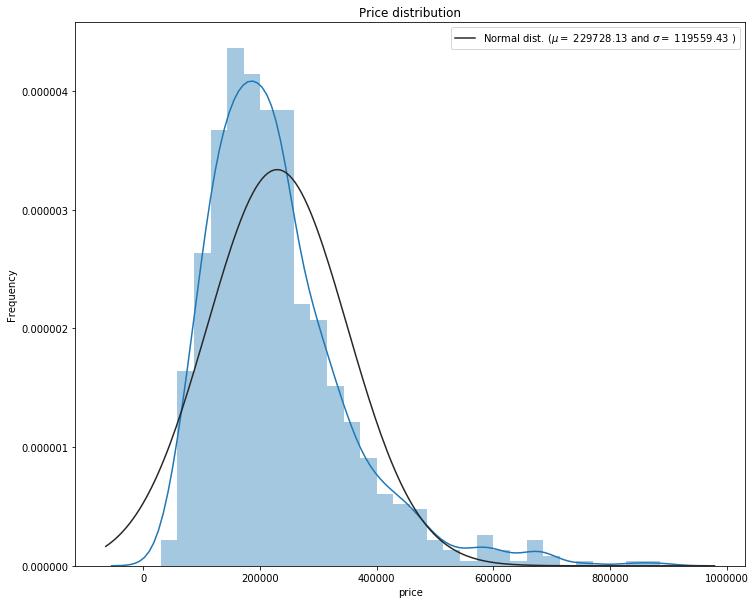

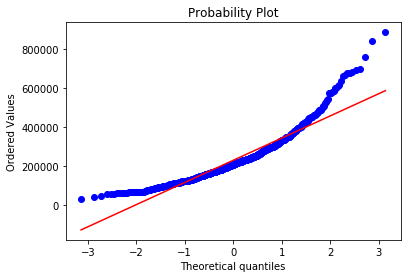

Skewness: 1.521667
Kurtosis: 3.610886


In [22]:
# Plot Histogram
plt.subplots(figsize=(12,10))
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())


Możemy zaobserwować, że zmienna docelowa:

- odbiega od rozkładu normalnego
- ma znacznie dodatnią skośność (prawostronna)
- Dane w modelach liniowych powinny mieć rozkład normalny, zmienimy te zmienną i sprawimy, że będzie miała rozkład bliski normalnemu.
- Modele drzewiaste powwinny poradzić sobie z tym problemem, jednak dla nich także zastosuje normalizacje zmiennej 'price'

In [23]:
#Użycie funkcji numpy 'log1p' w celu normalizacji zmiennej zależnej
df["price"] = np.log1p(df["price"])
#df["price"] = np.log(df["price"])


 mu = 12.22 and sigma = 0.50



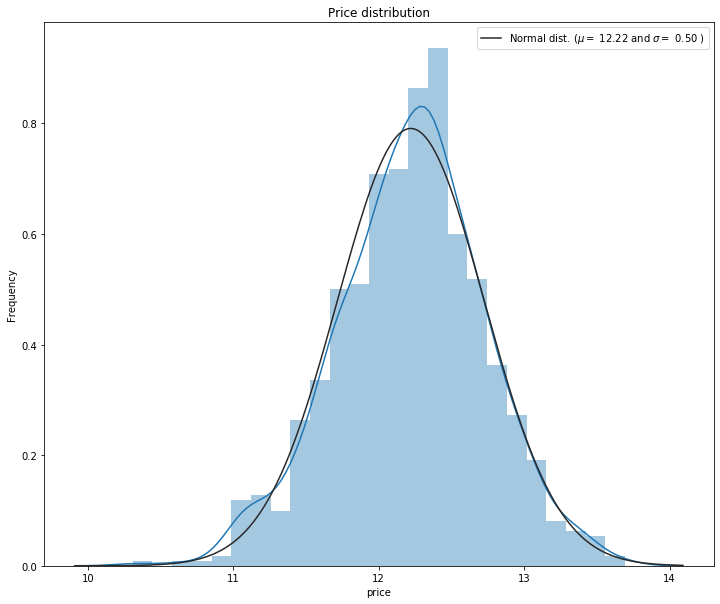

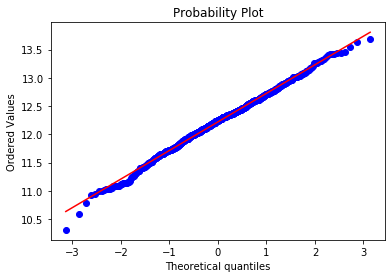

Skewness: -0.165897
Kurtosis: 0.220939


In [24]:
# Wyświetlenie histogramu po normalizacji
plt.subplots(figsize=(12,10))
sns.distplot(df['price'] , fit=norm);

(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

In [25]:
df['street'] = df['street'].str.replace(r'^[\d-]+', '')

In [26]:
df['street'].nunique()

755

In [27]:
df = df.drop(columns=['state'])
df = df.drop(columns=['street'])
df = df.drop(columns=['sale_date'])

In [28]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  7
Number of Categorical features:  2


In [29]:
print('Numerical features - ',df[numerical_feats].columns)
print("*"*100)
print('Categorical features - ', df[categorical_feats].columns)

Numerical features -  Index(['zip', 'beds', 'baths', 'sq__ft', 'price', 'latitude', 'longitude'], dtype='object')
****************************************************************************************************
Categorical features -  Index(['city', 'type'], dtype='object')


In [30]:
for catg in list(categorical_feats) :
    print(df[catg].value_counts())
    print('#'*50)

SACRAMENTO         424
ELK GROVE          107
CITRUS HEIGHTS      35
ANTELOPE            33
ROSEVILLE           28
NORTH HIGHLANDS     21
RANCHO CORDOVA      21
CARMICHAEL          20
GALT                20
FOLSOM              15
RIO LINDA           12
ORANGEVALE          11
FAIR OAKS            9
ROCKLIN              8
LINCOLN              6
PLACERVILLE          5
ELVERTA              4
WILTON               4
GRANITE BAY          3
EL DORADO HILLS      3
POLLOCK PINES        3
AUBURN               3
GOLD RIVER           3
EL DORADO            2
RANCHO MURIETA       2
LOOMIS               2
WEST SACRAMENTO      1
CAMERON PARK         1
MEADOW VISTA         1
GREENWOOD            1
COOL                 1
MATHER               1
DIAMOND SPRINGS      1
WALNUT GROVE         1
PENRYN               1
Name: city, dtype: int64
##################################################
Residential     758
Condo            42
Multi-Family     13
Name: type, dtype: int64
##################################

In [31]:
#Czyszczenie danych w kolumnie city
df['city'] = df['city'].str.lower().str.replace('sacramentos', 'sacramento')

In [32]:
# Usunięcie miast, które pojawiły się nie częściej, niż 2 razy
N=2
df=df[df.groupby('city')['city'].transform('count')>N]

In [33]:
df.loc[df['city'].value_counts()[df['city']].values < 4, 'city'] = "other"

In [34]:
for catg in list(categorical_feats) :
    print(df[catg].value_counts())
    print('#'*50)

sacramento         424
elk grove          107
citrus heights      35
antelope            33
roseville           28
north highlands     21
rancho cordova      21
carmichael          20
galt                20
folsom              15
other               15
rio linda           12
orangevale          11
fair oaks            9
rocklin              8
lincoln              6
placerville          5
elverta              4
wilton               4
Name: city, dtype: int64
##################################################
Residential     743
Condo            42
Multi-Family     13
Name: type, dtype: int64
##################################################


### 2.4 Data exploration after cleaning

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
zip,798.0,95763.518797,84.861133,95603.000000,95670.000000,95820.000000,95829.000000,95864.000000
beds,798.0,3.246867,0.856276,1.000000,3.000000,3.000000,4.000000,8.000000
baths,798.0,1.958647,0.664228,1.000000,2.000000,2.000000,2.000000,5.000000
sq__ft,798.0,1582.669173,646.614364,484.000000,1144.000000,1417.000000,1843.750000,4400.000000
price,798.0,12.211857,0.502528,10.308986,11.902303,12.240479,12.542548,13.693107
latitude,798.0,38.574937,0.123575,38.241514,38.473194,38.590701,38.673333,38.939802
longitude,798.0,-121.384303,0.110330,-121.550527,-121.451890,-121.408282,-121.330458,-120.597599


In [36]:
#Tymczasowo przekształcam zmienne 'city' i 'type' na zmienne kategoryczne, aby sprawdzić korelacje.
temp_df = df.copy()

In [37]:
from sklearn.preprocessing import LabelEncoder
listToEncode = ['city', 'type']
temp_df[listToEncode] = temp_df[listToEncode].apply(LabelEncoder().fit_transform)

In [38]:
print("Najbardziej skorelowane zmienne z ceną po normalizacji i czyszczeniu danych")
corr = temp_df.corr()
corr.sort_values(['price'], ascending=False, inplace=True)
corr.price

Najbardziej skorelowane zmienne z ceną po normalizacji i czyszczeniu danych


price        1.000000
sq__ft       0.707610
baths        0.536594
beds         0.484915
longitude    0.248450
type         0.233317
latitude     0.020436
zip         -0.222256
city        -0.237315
Name: price, dtype: float64

Zmienna zip:
- http://www.city-data.com/zips/95838.html  << Statystyki dla przykładowego kodu poczetowego z naszego zestawu danych.

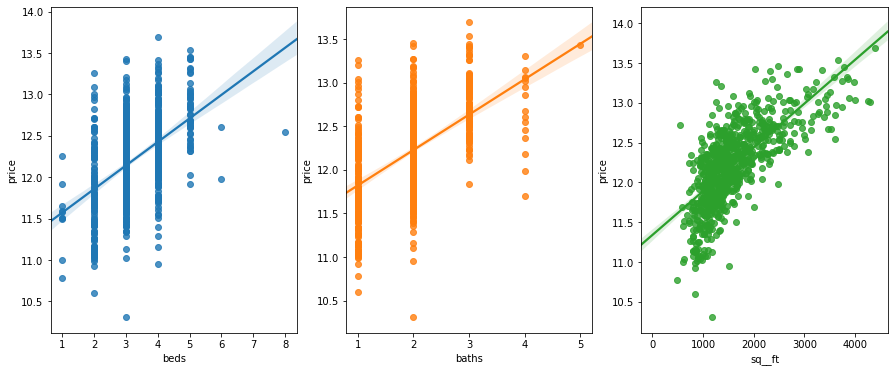

In [39]:
#Scatter Plots
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
beds_scatter_plot = pd.concat([df['price'],df['beds']],axis = 1)
sns.regplot(x='beds',y = 'price',data = beds_scatter_plot,scatter= True, fit_reg=True, ax=ax1)
beds_scatter_plot = pd.concat([df['price'],df['baths']],axis = 1)
sns.regplot(x='baths',y = 'price',data = beds_scatter_plot,scatter= True, fit_reg=True, ax=ax2)
beds_scatter_plot = pd.concat([df['price'],df['sq__ft']],axis = 1)
sns.regplot(x='sq__ft',y = 'price',data = beds_scatter_plot,scatter= True, fit_reg=True, ax=ax3)


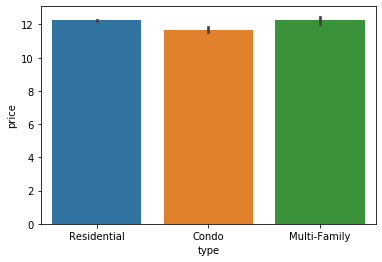

In [40]:
sns.barplot(df.type,df.price)

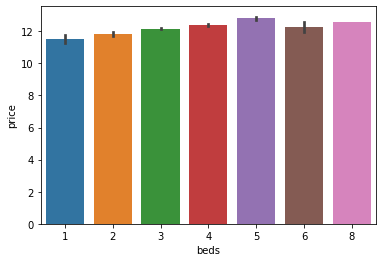

In [41]:
sns.barplot(df.beds,df.price)

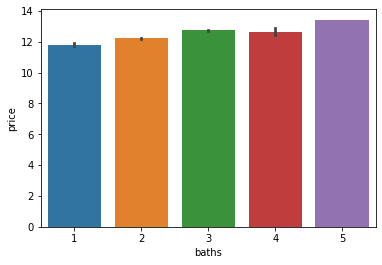

In [42]:
sns.barplot(df.baths,df.price)

In [43]:
# Straciliśmy około 20% danych
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 984
Data columns (total 9 columns):
city         798 non-null object
zip          798 non-null int64
beds         798 non-null int64
baths        798 non-null int64
sq__ft       798 non-null int64
type         798 non-null object
price        798 non-null float64
latitude     798 non-null float64
longitude    798 non-null float64
dtypes: float64(3), int64(4), object(2)
memory usage: 102.3+ KB


### 3. Feature engineering

In [44]:
from sklearn.cluster import DBSCAN
#from pygeocoder import Geocoder

In [45]:
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
coords = df.as_matrix(columns=['longitude', 'latitude'])
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [46]:
cluster_labels = db.labels_

In [47]:
num_clusters = len(set(cluster_labels))

In [48]:
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 42


In [49]:
df['cluster'] = db.labels_

### 4 Modelling

In [50]:
lin_df = df.copy() #Kopia zostanie wykorzystana do modeli liniowych

In [51]:
dl_df = df.copy() #Kopia zostanie wykorzystana do modeli deep learningowych

In [52]:
df = pd.get_dummies(df, columns=["beds", "baths", "city", "type", 'zip', 'cluster'])

In [53]:
X = df.drop(["price"],axis=1)
y = df['price']

In [54]:
# Dzielenie danych za zestaw treningowy i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .35, random_state = 0)

In [55]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 3.1 Base models

##### XGBOOST

In [56]:
xgb1 = XGBRegressor(
learning_rate=0.09,
max_depth=4,
min_child_weight=2,
subsample=0.7
)

In [57]:
xgb1.fit(X_train, y_train)

[04:04:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [58]:
# Predicting the Test set results
y_pred = xgb1.predict(X_test)

In [59]:
score = xgb1.score(X_test, y_test)
print(score*100)

67.69802794503863


In [60]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.21250782585820402
Mean Squared Error: 0.07519492503722053
Root Mean Squared Error: 0.27421693061738645


#### XGboost with grid search

In [42]:
xgb2 = XGBRegressor()

In [43]:
parameters = {'learning_rate': [0.09, 0.1, 0.2], 
              'min_child_weight':[1, 2, 3], 
              'gamma':[0, .1],
              'subsample':[.7, .8, .9, 1],
              'colsample_bytree':[.8, .9, 1], 
              'max_depth': [3, 4, 5], 
              'n_estimators': [100, 120] }

In [44]:
xgb_grid = GridSearchCV(xgb2,
                        parameters,
                        cv = 6,
                        n_jobs = -1,
                        verbose=True)

In [45]:
xgb_grid.fit(X_train, y_train)

Fitting 6 folds for each of 1296 candidates, totalling 7776 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 7776 out of 7776 | elapsed:  6.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: 

[03:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1], 'gamma': [0, 0.1],
                         'learning_rate': [0.09, 0.1, 0.2],
                         'max_depth': [3, 4, 

In [46]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.646070121795759
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 120, 'subsample': 0.8}


In [55]:
y_pred = xgb_grid.predict(X_test)

In [56]:
score = xgb_grid.score(X_test, y_test)
print(score*100)

63.121387985658274


In [57]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.22643461789103056
Mean Squared Error: 0.08584876679283855
Root Mean Squared Error: 0.2929996020352904


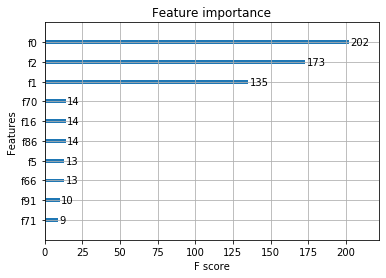

In [60]:
plot_importance(xgb1, max_num_features=10) # top 10 most important features
plt.show()

In [62]:
y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
pred_df= pd.DataFrame({'Real': y_test.flatten(), 'Pred': y_pred.flatten()})
pred_df.head(10)

,Real,Pred
0,12.254868,12.028738
1,11.034906,11.619061
2,12.352240,12.113425
3,12.272567,12.577984
4,12.814381,12.769642
5,12.559146,12.729629
6,11.970357,11.820525
7,12.402876,12.493791
8,12.691584,12.677387
9,11.752415,11.598308


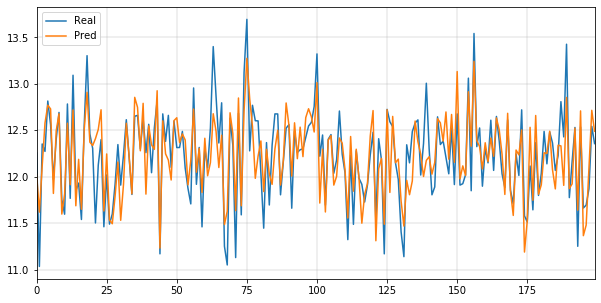

In [63]:
pred_df = pred_df.head(200)
pred_df.plot(kind='line',figsize=(10,5))
plt.grid(which='major',  linewidth='0.4')
plt.grid(which='minor', linewidth='0.4')
plt.show()

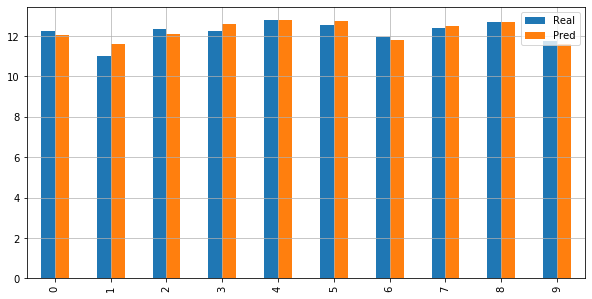

In [64]:
_pred_df = pred_df.head(10)
_pred_df.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linewidth='0.7')
plt.grid(which='minor', linewidth='0.7')
plt.show()

#### Linear regression
Dla modeli liniowych będziemy musieli zastosować także normalizacje zmiennej 'sq__ft' oraz zrezygnować z kilku ziennych 'Dummy'

Skewness: 1.495493
Kurtosis: 2.577878


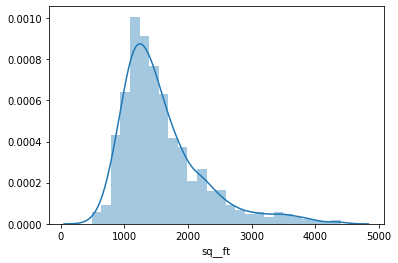

In [65]:
#
sns.distplot(lin_df['sq__ft']);
print("Skewness: %f" % lin_df['sq__ft'].skew())
print("Kurtosis: %f" % lin_df['sq__ft'].kurt())

In [61]:
lin_df['sq__ft_log'] = np.log(lin_df['sq__ft'])
lin_df.drop('sq__ft', inplace= True, axis = 1)

Skewness: 0.403035
Kurtosis: 0.137625


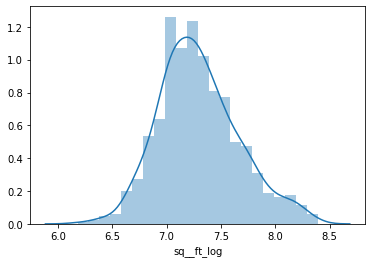

In [67]:
sns.distplot(lin_df['sq__ft_log']);
#skewness and kurtosis
print("Skewness: %f" % lin_df['sq__ft_log'].skew())
print("Kurtosis: %f" % lin_df['sq__ft_log'].kurt())

In [62]:
listToEncode = ['city', 'type',"beds", "baths"]
lin_df[listToEncode] = lin_df[listToEncode].apply(LabelEncoder().fit_transform)

In [63]:
X = lin_df.drop(["price"],axis=1)
y = lin_df['price']

In [64]:
# Dzielenie danych na zestaw testowy i treningowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .35, random_state = 0)

In [65]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [66]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [68]:
score = regressor.score(X_test, y_test)
print(score*100)

63.53073349355699


In [69]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.22387213639835532
Mean Squared Error: 0.08489586197549817
Root Mean Squared Error: 0.2913689447684811


#### SVR

In [76]:
# Fitting SVR to the dataset
svr_regressor = SVR(
    kernel='linear',
    C=10,
    epsilon=0.05
    )
svr_regressor.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [77]:
# Predicting the Test set results
y_pred = svr_regressor.predict(X_test)

In [78]:
score = svr_regressor.score(X_test, y_test)
print(score*100)

63.064156647237


In [79]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.22437963326962176
Mean Squared Error: 0.08598199414487281
Root Mean Squared Error: 0.29322686463704656


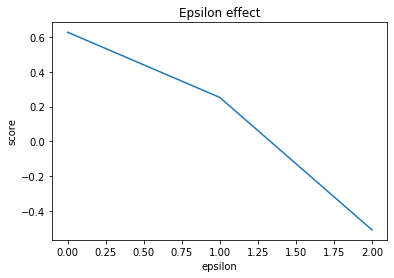

In [80]:
# Sprawdzmy inne wartosci dla epsilon
epsilons = np.arange(0, 3)
scores = []
for e in epsilons:
    svr_regressor.set_params(epsilon=e)
    svr_regressor.fit(X_train, y_train)
    scores.append(svr_regressor.score(X_test, y_test))
plt.plot(epsilons, scores)
plt.title("Epsilon effect")
plt.xlabel("epsilon")
plt.ylabel("score")
plt.show()

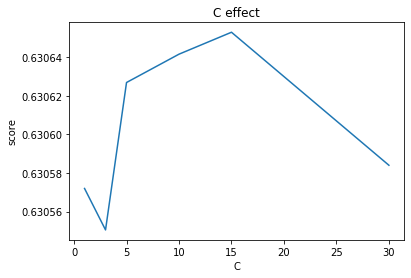

In [81]:
# Try other C's - This will take about a minute or so
svr_regressor.set_params(epsilon=0.05)
Cs = [1, 3, 5, 10, 15, 30]
scores = []
for c in Cs:
    svr_regressor.set_params(C=c)
    svr_regressor.fit(X_train, y_train)
    scores.append(svr_regressor.score(X_test, y_test))
plt.plot(Cs, scores)
plt.title("C effect")
plt.xlabel("C")
plt.ylabel("score")
plt.show()

#### Neural network

In [70]:
dl_df.head()

,city,zip,beds,baths,sq__ft,type,price,latitude,longitude,cluster
0,sacramento,95838,2,1,836,Residential,10.989065,38.631913,-121.434879,0
1,sacramento,95823,3,1,1167,Residential,11.130390,38.478902,-121.431028,1
2,sacramento,95815,2,1,796,Residential,11.140136,38.618305,-121.443839,0
3,sacramento,95815,2,1,852,Residential,11.146316,38.616835,-121.439146,0
4,sacramento,95824,2,1,797,Residential,11.313266,38.519470,-121.435768,1


In [71]:
dl_df = dl_df.drop(columns=['cluster'])

In [72]:
dl_df = pd.get_dummies(dl_df, columns=["beds", "baths", "city", "type", 'zip'])

In [73]:
X = dl_df.drop(["price"],axis=1)
y = dl_df['price']

In [74]:
# Dzielenie danych na zestaw testowy i treningowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .35, random_state = 0)

In [75]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [76]:
model=Sequential()
model.add(Dense(270,input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(120))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Dense(output_dim=1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='Adam', metrics =['mae'])
model.summary()
print(X_train.shape)
hist = model.fit(X_train,y_train,
          validation_split=.2,
          epochs=800,
          batch_size=20,
          verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 270)               24840     
_________________________________________________________________
dropout_1 (Dropout)          (None, 270)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               32520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

Epoch 50/800
414/414 [==============================] - 0s 115us/step - loss: 2.9862 - mae: 1.2849 - val_loss: 483.0521 - val_mae: 3.5943
Epoch 51/800
414/414 [==============================] - 0s 110us/step - loss: 2.4178 - mae: 1.1989 - val_loss: 477.6429 - val_mae: 3.5870
Epoch 52/800
414/414 [==============================] - 0s 124us/step - loss: 2.5748 - mae: 1.2085 - val_loss: 506.8773 - val_mae: 3.6436
Epoch 53/800
414/414 [==============================] - 0s 118us/step - loss: 2.4324 - mae: 1.2282 - val_loss: 489.2665 - val_mae: 3.6181
Epoch 54/800
414/414 [==============================] - 0s 100us/step - loss: 2.5519 - mae: 1.1544 - val_loss: 489.1427 - val_mae: 3.6836
Epoch 55/800
414/414 [==============================] - 0s 105us/step - loss: 2.5346 - mae: 1.1703 - val_loss: 498.2638 - val_mae: 3.6053
Epoch 56/800
414/414 [==============================] - 0s 98us/step - loss: 2.9395 - mae: 1.2595 - val_loss: 480.1399 - val_mae: 3.6205
Epoch 57/800
414/414 [=============

414/414 [==============================] - 0s 115us/step - loss: 1.6533 - mae: 0.9519 - val_loss: 326.0610 - val_mae: 2.9071
Epoch 110/800
414/414 [==============================] - 0s 113us/step - loss: 1.3839 - mae: 0.9232 - val_loss: 352.6692 - val_mae: 3.0249
Epoch 111/800
414/414 [==============================] - 0s 108us/step - loss: 1.5625 - mae: 0.9588 - val_loss: 330.3992 - val_mae: 2.8528
Epoch 112/800
414/414 [==============================] - 0s 105us/step - loss: 1.1689 - mae: 0.8574 - val_loss: 313.5207 - val_mae: 2.9056
Epoch 113/800
414/414 [==============================] - 0s 114us/step - loss: 1.2463 - mae: 0.8336 - val_loss: 307.7067 - val_mae: 2.8705
Epoch 114/800
414/414 [==============================] - 0s 106us/step - loss: 1.2673 - mae: 0.8650 - val_loss: 301.5379 - val_mae: 2.8941
Epoch 115/800
414/414 [==============================] - 0s 116us/step - loss: 1.3437 - mae: 0.9069 - val_loss: 313.4011 - val_mae: 2.8908
Epoch 116/800
414/414 [==================

414/414 [==============================] - 0s 117us/step - loss: 0.8065 - mae: 0.7257 - val_loss: 153.3389 - val_mae: 2.0310
Epoch 169/800
414/414 [==============================] - 0s 105us/step - loss: 0.7971 - mae: 0.7188 - val_loss: 153.1400 - val_mae: 2.0431
Epoch 170/800
414/414 [==============================] - 0s 117us/step - loss: 0.9989 - mae: 0.7476 - val_loss: 134.2684 - val_mae: 2.0179
Epoch 171/800
414/414 [==============================] - 0s 119us/step - loss: 1.2913 - mae: 0.7698 - val_loss: 148.7898 - val_mae: 2.0389
Epoch 172/800
414/414 [==============================] - 0s 114us/step - loss: 0.8513 - mae: 0.7130 - val_loss: 131.3879 - val_mae: 2.0351
Epoch 173/800
414/414 [==============================] - 0s 110us/step - loss: 0.7462 - mae: 0.6817 - val_loss: 136.8688 - val_mae: 1.9422
Epoch 174/800
414/414 [==============================] - 0s 107us/step - loss: 0.8667 - mae: 0.7218 - val_loss: 136.1547 - val_mae: 1.9465
Epoch 175/800
414/414 [==================

414/414 [==============================] - 0s 107us/step - loss: 0.5373 - mae: 0.5716 - val_loss: 35.7547 - val_mae: 1.1549
Epoch 228/800
414/414 [==============================] - 0s 103us/step - loss: 0.5234 - mae: 0.5496 - val_loss: 38.8115 - val_mae: 1.2364
Epoch 229/800
414/414 [==============================] - 0s 101us/step - loss: 0.5184 - mae: 0.5646 - val_loss: 35.2909 - val_mae: 1.2060
Epoch 230/800
414/414 [==============================] - 0s 101us/step - loss: 0.5394 - mae: 0.5832 - val_loss: 40.1083 - val_mae: 1.2054
Epoch 231/800
414/414 [==============================] - 0s 118us/step - loss: 0.5312 - mae: 0.5610 - val_loss: 37.5026 - val_mae: 1.1826
Epoch 232/800
414/414 [==============================] - 0s 123us/step - loss: 0.5287 - mae: 0.5591 - val_loss: 29.4193 - val_mae: 1.0923
Epoch 233/800
414/414 [==============================] - 0s 107us/step - loss: 0.5836 - mae: 0.6061 - val_loss: 27.6902 - val_mae: 1.0376
Epoch 234/800
414/414 [=========================

414/414 [==============================] - 0s 105us/step - loss: 0.2949 - mae: 0.4271 - val_loss: 6.9333 - val_mae: 0.6936
Epoch 287/800
414/414 [==============================] - 0s 113us/step - loss: 0.4343 - mae: 0.4987 - val_loss: 7.3177 - val_mae: 0.6716
Epoch 288/800
414/414 [==============================] - 0s 120us/step - loss: 0.3419 - mae: 0.4579 - val_loss: 7.9119 - val_mae: 0.6601
Epoch 289/800
414/414 [==============================] - 0s 115us/step - loss: 0.3545 - mae: 0.4617 - val_loss: 7.4958 - val_mae: 0.6542
Epoch 290/800
414/414 [==============================] - 0s 107us/step - loss: 0.3334 - mae: 0.4564 - val_loss: 7.0864 - val_mae: 0.6479
Epoch 291/800
414/414 [==============================] - 0s 115us/step - loss: 0.3788 - mae: 0.4814 - val_loss: 6.7570 - val_mae: 0.6521
Epoch 292/800
414/414 [==============================] - 0s 105us/step - loss: 0.3531 - mae: 0.4599 - val_loss: 5.8423 - val_mae: 0.6395
Epoch 293/800
414/414 [==============================] 

Epoch 346/800
414/414 [==============================] - 0s 106us/step - loss: 0.2363 - mae: 0.3794 - val_loss: 1.2983 - val_mae: 0.4321
Epoch 347/800
414/414 [==============================] - 0s 110us/step - loss: 0.2257 - mae: 0.3669 - val_loss: 0.9815 - val_mae: 0.4014
Epoch 348/800
414/414 [==============================] - 0s 104us/step - loss: 0.2557 - mae: 0.3901 - val_loss: 0.9131 - val_mae: 0.3913
Epoch 349/800
414/414 [==============================] - 0s 107us/step - loss: 0.2379 - mae: 0.3931 - val_loss: 0.9498 - val_mae: 0.3935
Epoch 350/800
414/414 [==============================] - 0s 109us/step - loss: 0.2589 - mae: 0.3945 - val_loss: 1.3223 - val_mae: 0.4223
Epoch 351/800
414/414 [==============================] - 0s 103us/step - loss: 0.2291 - mae: 0.3781 - val_loss: 1.4235 - val_mae: 0.4309
Epoch 352/800
414/414 [==============================] - 0s 103us/step - loss: 0.2123 - mae: 0.3627 - val_loss: 1.5115 - val_mae: 0.4380
Epoch 353/800
414/414 [==================

Epoch 406/800
414/414 [==============================] - 0s 106us/step - loss: 0.1831 - mae: 0.3413 - val_loss: 0.3193 - val_mae: 0.3271
Epoch 407/800
414/414 [==============================] - 0s 121us/step - loss: 0.1726 - mae: 0.3307 - val_loss: 0.3490 - val_mae: 0.3217
Epoch 408/800
414/414 [==============================] - 0s 104us/step - loss: 0.1465 - mae: 0.2977 - val_loss: 0.4254 - val_mae: 0.3453
Epoch 409/800
414/414 [==============================] - 0s 109us/step - loss: 0.1650 - mae: 0.3195 - val_loss: 0.5372 - val_mae: 0.3522
Epoch 410/800
414/414 [==============================] - 0s 111us/step - loss: 0.1416 - mae: 0.2943 - val_loss: 0.5160 - val_mae: 0.3698
Epoch 411/800
414/414 [==============================] - 0s 128us/step - loss: 0.1710 - mae: 0.3216 - val_loss: 0.6839 - val_mae: 0.3796
Epoch 412/800
414/414 [==============================] - 0s 118us/step - loss: 0.1528 - mae: 0.3106 - val_loss: 0.7387 - val_mae: 0.4055
Epoch 413/800
414/414 [==================

Epoch 466/800
414/414 [==============================] - 0s 110us/step - loss: 0.1190 - mae: 0.2672 - val_loss: 0.2327 - val_mae: 0.3133
Epoch 467/800
414/414 [==============================] - 0s 105us/step - loss: 0.1180 - mae: 0.2667 - val_loss: 0.2506 - val_mae: 0.3401
Epoch 468/800
414/414 [==============================] - 0s 109us/step - loss: 0.1148 - mae: 0.2612 - val_loss: 0.2671 - val_mae: 0.3290
Epoch 469/800
414/414 [==============================] - 0s 111us/step - loss: 0.1268 - mae: 0.2756 - val_loss: 0.2263 - val_mae: 0.3017
Epoch 470/800
414/414 [==============================] - 0s 108us/step - loss: 0.1013 - mae: 0.2519 - val_loss: 0.2447 - val_mae: 0.3035
Epoch 471/800
414/414 [==============================] - 0s 113us/step - loss: 0.1174 - mae: 0.2612 - val_loss: 0.2796 - val_mae: 0.3320
Epoch 472/800
414/414 [==============================] - 0s 107us/step - loss: 0.1168 - mae: 0.2592 - val_loss: 0.2835 - val_mae: 0.3165
Epoch 473/800
414/414 [==================

Epoch 526/800
414/414 [==============================] - 0s 110us/step - loss: 0.0826 - mae: 0.2163 - val_loss: 0.2783 - val_mae: 0.3418
Epoch 527/800
414/414 [==============================] - 0s 111us/step - loss: 0.0939 - mae: 0.2353 - val_loss: 0.3022 - val_mae: 0.3345
Epoch 528/800
414/414 [==============================] - 0s 102us/step - loss: 0.0921 - mae: 0.2312 - val_loss: 0.2887 - val_mae: 0.3298
Epoch 529/800
414/414 [==============================] - 0s 109us/step - loss: 0.0870 - mae: 0.2303 - val_loss: 0.3193 - val_mae: 0.3723
Epoch 530/800
414/414 [==============================] - 0s 115us/step - loss: 0.0926 - mae: 0.2320 - val_loss: 0.2322 - val_mae: 0.3038
Epoch 531/800
414/414 [==============================] - 0s 108us/step - loss: 0.0857 - mae: 0.2248 - val_loss: 0.1979 - val_mae: 0.2926
Epoch 532/800
414/414 [==============================] - 0s 113us/step - loss: 0.0829 - mae: 0.2245 - val_loss: 0.2293 - val_mae: 0.3030
Epoch 533/800
414/414 [==================

Epoch 586/800
414/414 [==============================] - 0s 117us/step - loss: 0.0775 - mae: 0.2139 - val_loss: 0.1570 - val_mae: 0.2892
Epoch 587/800
414/414 [==============================] - 0s 111us/step - loss: 0.0880 - mae: 0.2253 - val_loss: 0.1675 - val_mae: 0.3232
Epoch 588/800
414/414 [==============================] - 0s 116us/step - loss: 0.0816 - mae: 0.2164 - val_loss: 0.1402 - val_mae: 0.2712
Epoch 589/800
414/414 [==============================] - 0s 108us/step - loss: 0.0730 - mae: 0.2079 - val_loss: 0.1375 - val_mae: 0.2702
Epoch 590/800
414/414 [==============================] - 0s 105us/step - loss: 0.0769 - mae: 0.2089 - val_loss: 0.1433 - val_mae: 0.2679
Epoch 591/800
414/414 [==============================] - 0s 122us/step - loss: 0.0782 - mae: 0.2094 - val_loss: 0.1517 - val_mae: 0.2797
Epoch 592/800
414/414 [==============================] - 0s 115us/step - loss: 0.0784 - mae: 0.2103 - val_loss: 0.1534 - val_mae: 0.2747
Epoch 593/800
414/414 [==================

Epoch 646/800
414/414 [==============================] - 0s 99us/step - loss: 0.0822 - mae: 0.2159 - val_loss: 0.1907 - val_mae: 0.3005
Epoch 647/800
414/414 [==============================] - 0s 116us/step - loss: 0.0737 - mae: 0.2002 - val_loss: 0.2208 - val_mae: 0.3109
Epoch 648/800
414/414 [==============================] - 0s 109us/step - loss: 0.0749 - mae: 0.2078 - val_loss: 0.2546 - val_mae: 0.3396
Epoch 649/800
414/414 [==============================] - 0s 118us/step - loss: 0.0804 - mae: 0.2152 - val_loss: 0.2123 - val_mae: 0.3087
Epoch 650/800
414/414 [==============================] - 0s 121us/step - loss: 0.0793 - mae: 0.2111 - val_loss: 0.1470 - val_mae: 0.2830
Epoch 651/800
414/414 [==============================] - 0s 125us/step - loss: 0.0787 - mae: 0.2105 - val_loss: 0.1435 - val_mae: 0.2770
Epoch 652/800
414/414 [==============================] - 0s 107us/step - loss: 0.0873 - mae: 0.2239 - val_loss: 0.1390 - val_mae: 0.2747
Epoch 653/800
414/414 [===================

Epoch 706/800
414/414 [==============================] - 0s 113us/step - loss: 0.0794 - mae: 0.2062 - val_loss: 0.1729 - val_mae: 0.2954
Epoch 707/800
414/414 [==============================] - 0s 114us/step - loss: 0.0788 - mae: 0.2109 - val_loss: 0.1400 - val_mae: 0.2711
Epoch 708/800
414/414 [==============================] - 0s 117us/step - loss: 0.0755 - mae: 0.2058 - val_loss: 0.1752 - val_mae: 0.3190
Epoch 709/800
414/414 [==============================] - 0s 108us/step - loss: 0.0845 - mae: 0.2162 - val_loss: 0.1412 - val_mae: 0.2765
Epoch 710/800
414/414 [==============================] - 0s 104us/step - loss: 0.0806 - mae: 0.2132 - val_loss: 0.1320 - val_mae: 0.2601
Epoch 711/800
414/414 [==============================] - 0s 106us/step - loss: 0.0785 - mae: 0.2105 - val_loss: 0.1916 - val_mae: 0.3113
Epoch 712/800
414/414 [==============================] - 0s 109us/step - loss: 0.0795 - mae: 0.2110 - val_loss: 0.2442 - val_mae: 0.3196
Epoch 713/800
414/414 [==================

Epoch 766/800
414/414 [==============================] - 0s 113us/step - loss: 0.0835 - mae: 0.2178 - val_loss: 0.2282 - val_mae: 0.3383
Epoch 767/800
414/414 [==============================] - 0s 130us/step - loss: 0.0938 - mae: 0.2307 - val_loss: 0.1351 - val_mae: 0.2740
Epoch 768/800
414/414 [==============================] - 0s 109us/step - loss: 0.0819 - mae: 0.2148 - val_loss: 0.1507 - val_mae: 0.2809
Epoch 769/800
414/414 [==============================] - 0s 117us/step - loss: 0.0833 - mae: 0.2142 - val_loss: 0.1990 - val_mae: 0.3033
Epoch 770/800
414/414 [==============================] - 0s 110us/step - loss: 0.0767 - mae: 0.2058 - val_loss: 0.1464 - val_mae: 0.2759
Epoch 771/800
414/414 [==============================] - 0s 136us/step - loss: 0.0796 - mae: 0.2132 - val_loss: 0.1337 - val_mae: 0.2665
Epoch 772/800
414/414 [==============================] - 0s 121us/step - loss: 0.0815 - mae: 0.2135 - val_loss: 0.1751 - val_mae: 0.3013
Epoch 773/800
414/414 [==================

In [77]:
result = model.evaluate(X_test, y_test, verbose=0)
result

[0.16600937162126814, 0.28187909722328186]

In [78]:
model.evaluate(X_test, y_test)[1]

280/280 [==============================] - 0s 35us/step


0.28187909722328186

In [79]:
hist.history.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

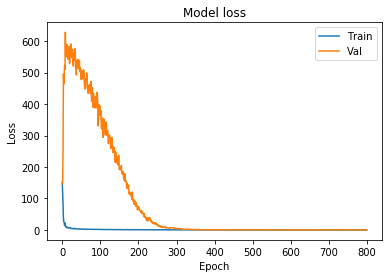

In [80]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## 4. Wnioski

- Model XGBOOST osiągnął najmniejszy błąd średniokwadratowy zajmując tym samym pierwsze miejsce.

- Po normalizacji zmiennej "sq__ft" modele liniowe (regresja liniowa, liniowy SVR) wypadły niewiele gorzej. Jeśli zależałoby mi na prostym modelu to wybrałbym regresje liniową. 

- Wynik sieci neuronowej nie jest najlepszy. myślę, że model działa źle, ponieważ mamy dość mały zestaw danych. Sieć neuronowa działa najlepiej na dużych zbiorach danych.

Pozostałe sprawdzane modele - lasso, ridge, random forest wypadły podobnie.